# Large attachment failures in requesting TPP practices

Questions:

- Can we reliably identify GP2GP conversations that have failed due to TPP’s attachment size constraints?
- For such conversations, can we identify the size of the largest attachment?
- Given a proposed attachment size limit, can we estimate the number of transfer failures that will occur due to breaching this limit?
- Are there any trends in attachment size that may impact on our findings in the future? (e.g. is there a trend for attaching larger files to patient records?)

In [1]:
import paths
%load_ext autoreload
%autoreload 2

## Coverage of large message failures in the MI data

- We know that the MI data isn't always reliable
- We assume that the `spine2-live` index in NMS is more complete, as NHSD has complete observability for it
- We believe that by comparing large message error volumes in MI and in spine, we should be able to get some insight into the value of the MI data for addressing these issues

### According to Spine

NMS query to retrieve all large message errors from spine (regardless of whether generated by the sender or the requestor):
```
index="spine2-live" service="gp2gp" ackExceptionCode=30
| stats count, dc(conversationID) as distinct_conversations
```

Running this query for 1st May - 31st Aug 2019 gave:

```
count: 6886
distinct_conversations: 4501
```

That is, there were `6886` spine messages with `ackExceptionCode = 30` (i.e. Application Acknowledgement messages with `large message general failures` according to the gp2gp spec), and these occurred over `4501` unique conversations.

Interestingly, one conversation (`A2625E20-AEB5-11E9-83F0-5DB7E689278A`) was responsible for `1687` of the messages with `ackExceptionCode=30`:

| conversationID | number of code 30 messages |
|----------------|----------------------------|
|A2625E20-AEB5-11E9-83F0-5DB7E689278A	|1687 |
|940B37C0-8921-11E9-B15C-B3A7C3785255	|345  |
|725DA130-8C28-11E9-AEB6-CF3BB683BBAB	|134  |
|94EA0CD0-9E5B-11E9-865E-BDC4D55190ED	|9    |
|47A8BBF0-B473-11E9-9C99-370CE1778A36	|7    |
|3EF8D180-8B96-11E9-B31C-ADAEEF859273	|6    |

TODO:

- codes `29` and `31` are also associated with large message errors -- do we see any of these in practice? associated with TPP?

### According to the MI data

For the MI data, we have both the 'sender' and 'requestor' views of each conversation.  All the following queries run for May 1st - August 31st 2019.

#### From the sender perspective - looking at request acknowledgement errors

```
index="gp2gp-mi" sourcetype="gppractice-SR" RequestAckCode=30
| stats count, dc(ConversationID) as distinct_conversations
```

Results:
```
count: 2910
distinct_count: 2910
```

#### From the requestor perspective - looking at request errors

```
index="gp2gp-mi" sourcetype="gppractice-RR" RequestErrorCode=30
| stats count, dc(ConversationID) as distinct_conversations
```

Results:

```
count: 2805
distinct_conversations: 2775
```

#### From the requestor perspective - looking at extract acknowledgement errors

```
index="gp2gp-mi" sourcetype="gppractice-RR" ExtractAckCode=30
| stats count, dc(ConversationID) as distinct_conversations
```

Results:

```
count: 1557
distinct_count: 1557
```

#### Merging all of the above:

```
index="gp2gp-mi" sourcetype="gppractice-SR" RequestAckCode=30
| append [search index="gp2gp-mi" sourcetype="gppractice-RR" ExtractAckCode=30]
| append [search index="gp2gp-mi" sourcetype="gppractice-RR" RequestErrorCode=30]
| stats dc(eval(upper(ConversationID))) as distinct_conversations
```

Results:

```
distinct_conversations: 4467
```

### Conclusion

The results from the MI data are very close to the spine results --- the discrepancy may be plausibly explained by the lag in MI reporting.

**Thus: we can be confident in using the MI data to analyse 'error code 30' events --- i.e. `large message general failures`**.

## Supplier breakdown of large message issues

```
index="gp2gp-mi" sourcetype="gppractice-RR" ExtractAckCode=30 OR RequestErrorCode=30
| lookup GP2GP-Practice-Lookup PracticeCode AS RequestorODS OUTPUTNEW CurrentClinicalSupplier as requestor_supplier
| lookup GP2GP-Practice-Lookup PracticeCode AS SenderODS OUTPUTNEW CurrentClinicalSupplier as sender_supplier
| search (requestor_supplier="TPP" OR requestor_supplier="EMIS") AND (sender_supplier="TPP" OR sender_supplier="EMIS")
| eval RR8=coalesce(RequestFailurePoint, "-")
| eval RR11=coalesce(RequestFailureType, "-") 
| eval RR12=coalesce(RequestErrorCode, "-")
| eval RR22=coalesce(ExtractAckStatus, "-") 
| eval RR23=coalesce(ExtractAckCode, "-")
| eval trace=RR8 + "_" + RR11  + "_" + RR12  + "_" + RR22 + "_" + RR23
| stats values(trace) as traces by ConversationID, requestor_supplier, sender_supplier
| eval traces=mvjoin(traces, ", ") 
| stats dc(ConversationID) by traces, requestor_supplier, sender_supplier
```

For May 1st to Aug 31st 2019:

| RR8_RR11_RR12_RR22_RR23 | requestor | sender | # convs |
|-------------------------|-----------|--------|---------|
| `60_1_100_1_30`         | TPP       | EMIS   | **1477**|
| `60_6_30_-_-`           | EMIS      | TPP    | **2666**|
| `60_1_101_1_30`         | TPP       | EMIS   | 1       |
| `60_6_30_-_-`           | EMIS      | EMIS   | 36      |
| `60_1_100_1_30`         | EMIS      | EMIS   | 19      |
| `60_1_100_1_30`         | EMIS      | TPP    | 2       |
| `60_1_100_1_30`         | TPP       | TPP    | 31      |
| `60_6_30_-_-`           | TPP       | TPP    | 23      |

Comments:

- Details on the meaning of the `RRxx`s is given in the GP2GP MI specification. 
- Note that this query assumes that the current supplier for a practice was the supplier for the entire time period over which the query was run --- for some practices, this won't be true (i.e. an EMIS practice may have switched to TPP and v.v.); this is likely to be the case for the last 5 entries in the table above --- we will ignore these cases.
- For TPP as a sending practice, the `60_6_30_-_-` is the most common outcome; this corresponds to a 'large message general failure' at the sending practice end.
- For TPP as a receiving practice, the `60_1_100_1_30` is the most common outcome; this corresponds to large messages received by TPP where at least one attachment is larger than the TPP limit (currently 50Mb).


## Impact of increasing TPP attachment size limit

For the `60_1_100_1_30` cases, the `RequestErrorDescription` includes text that identifies the size of the largest attachment, e.g.:

> Attachment size : 62546892 is larger than TPP limit : 52428800

Thus, we can use the following query to extract the sizes of these attachments, and get some insight into the impact of increasing the TPP attachment limit:

```
index="gp2gp-mi" sourcetype="gppractice-RR"
| eval key=RegistrationTime + "-" + RegistrationSmartcardUID
| eval month=substr(RegistrationTime, 6, 2)
| rex "Attachment size (after decompression)?: (?<attachment_size>\d+) is larger than TPP limit"
| eval attachment_size_mb=attachment_size / (1024 * 1024)
| search attachment_size=*
| table key, month, RequestorODS, attachment_size_mb
```

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

In [3]:
import data

In [4]:
attachment_sizes_df = pd.read_csv(
    data.PRMT_372_attachment_sizes.path,
    index_col="key"
)

In [5]:
attachment_sizes_df.columns

Index(['month', 'RequestorODS', 'attachment_size_mb'], dtype='object')

In [6]:
len(attachment_sizes_df)

1556

In [7]:
attachment_sizes_df

,month,RequestorODS,attachment_size_mb
key,,,
2019-08-31T11:23:38-565335293109,8,E87024,68.975689
2019-08-31T14:36:02-557918326105,8,E87037,108.470928
2019-08-29T16:09:57-242182364560,8,J82194,79.232189
2019-08-22T15:53:28-533939102034,8,M85113,69.693462
2019-08-23T09:56:22-560494564107,8,M85117,62.745937
...,...,...,...
2019-05-07T14:04:47-565420527101,5,A83012,52.528641
2019-05-08T09:30:38-600346617035,5,C81017,58.094444
2019-05-07T17:36:05-560213475105,5,A86036,60.849609


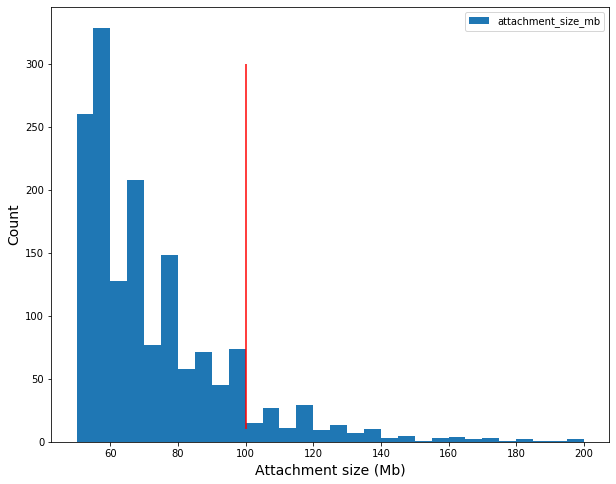

In [8]:
(attachment_sizes_df[["attachment_size_mb"]]
 .plot.hist(
     bins=np.linspace(50, 200, 150/5 + 1),
     figsize=(10,8),
 )
);
plt.xlabel("Attachment size (Mb)", size=14);
plt.ylabel("Count", size=14);
plt.vlines([100], 10, 300, color="r");

## GP2GP outcomes based on MI data for TPP practices

Preliminary notes:

- The number of registration events that terminate in an unambiguous 'general large message failure' is nowhere near the total number of 'failures' observed in requesting TPP practices in PRMT-365.
  => Need to get the numbers and show here
- Digging deeper into this, most of the 'failures' in PRMT-365 were 0-xx type: that is, no acknowledgement was ever sent (and in particular, no explicit *failure* was reported in the MI data).
- Picking a specific practice (M85046), and look in detail at failures of this kind in the `spine2-live` dataset indicated that often an 'Extract acknowledgement' message *was* sent in spine, but the details of this message were not recorded in the MI spec.
- Also, in a large number of the registration events looked at in this way, the ExtractAcks were sent on the same date (2019-05-14), despite the original request being made on different days, typically much earlier in the month (05-02 to 05-09).

This suggests that we need to follow up in more detail with TPP on conditions in which they do not record ExtractAck message details in MI.

It also suggests that we can't easily determine the actual rate of failures from the MI data, at least for TPP practices --- I'm *much* less confident in the MI data as a result of this exploration.

```
search index="gp2gp-mi" sourcetype="gppractice-RR"
| eval key=RegistrationTime + "-" + RegistrationSmartcardUID
| lookup GP2GP-Practice-Lookup PracticeCode AS RequestorODS OUTPUTNEW CurrentClinicalSupplier as requestor_supplier
```